# 🔥 Tracing the Scars of Fire: Geospatial Analysis of South Korea's 2025 Wildfire

### Jay Hee Won


### Summary

From March 22 to March 28, 2025, South Korea experienced its most devastating wildfire in recorded history, primarily affecting the southeastern region. This geospatial mini-study leverages Google Earth Engine (GEE) to assess environmental damage, investigate the fire's origin, and evaluate whether long-standing climate trends had signaled such risks in advance — and if policy inertia contributed to the catastrophe.

In [ ]:
pip install earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


In [ ]:
pip install xee

In [ ]:
import ee
import xee
import geemap as gee
import xarray as xr
import matplotlib.pyplot as plt


ee.Authenticate()
ee.Initialize(project="st446-first-j")


In [ ]:

Map = gee.Map(basemap='TERRAIN')
Map.add_basemap('SATELLITE')


### 1. Tracking Vegetation Loss Using VIIRS-Derived NDVI

To assess the environmental damage of the wildfire, I calculated the Normalized Difference Vegetation Index (NDVI) using NASA’s VIIRS Surface Reflectance product (VNP09GA). Specifically, I used bands I1 (red) and I2 (near-infrared), computing NDVI as:

$$
NDVI= \frac{I_2 - I_1}{I_2 + I_1}
$$

NDVI is a widely accepted proxy for vegetation health and density — healthy vegetation reflects more near-infrared and absorbs more red light. By mapping NDVI across the affected area over time (March 21–28), I could trace where vegetation sharply declined, a clear signal of wildfire impact.

In [ ]:
roi = ee.Geometry.BBox(128.0, 36.2, 129.6, 37.00)


In [ ]:

time_start = ee.Date('2025-03-21')
time_end = ee.Date('2025-03-28')

sr  = ee.ImageCollection("NASA/VIIRS/002/VNP09GA").filterDate(time_start, time_end).select('I1','I2')

def ndvi(img):
  index = img.normalizedDifference(['I2','I1']).rename('ndvi')
  return index.copyProperties(img, img.propertyNames())

viirs_ndvi = sr.map(ndvi)

ds_ndvi  = xr.open_dataset(viirs_ndvi, engine = 'ee', crs = 'EPSG:4326', scale = 0.001, geometry = roi)



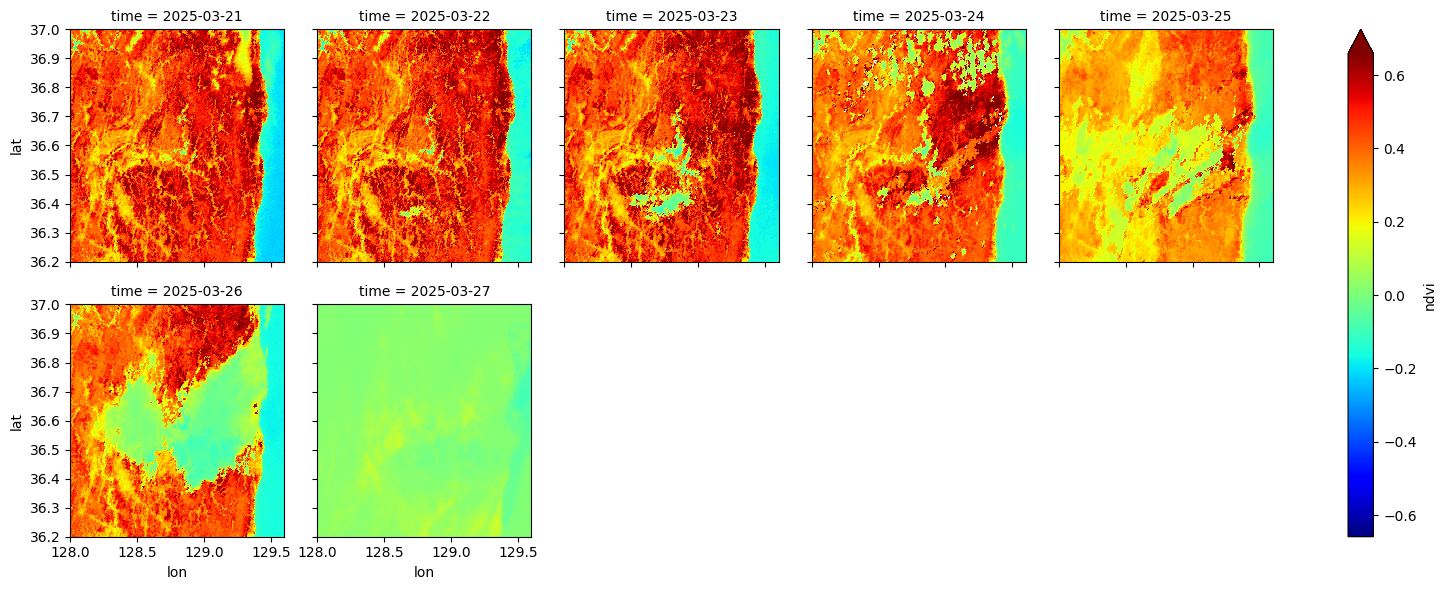

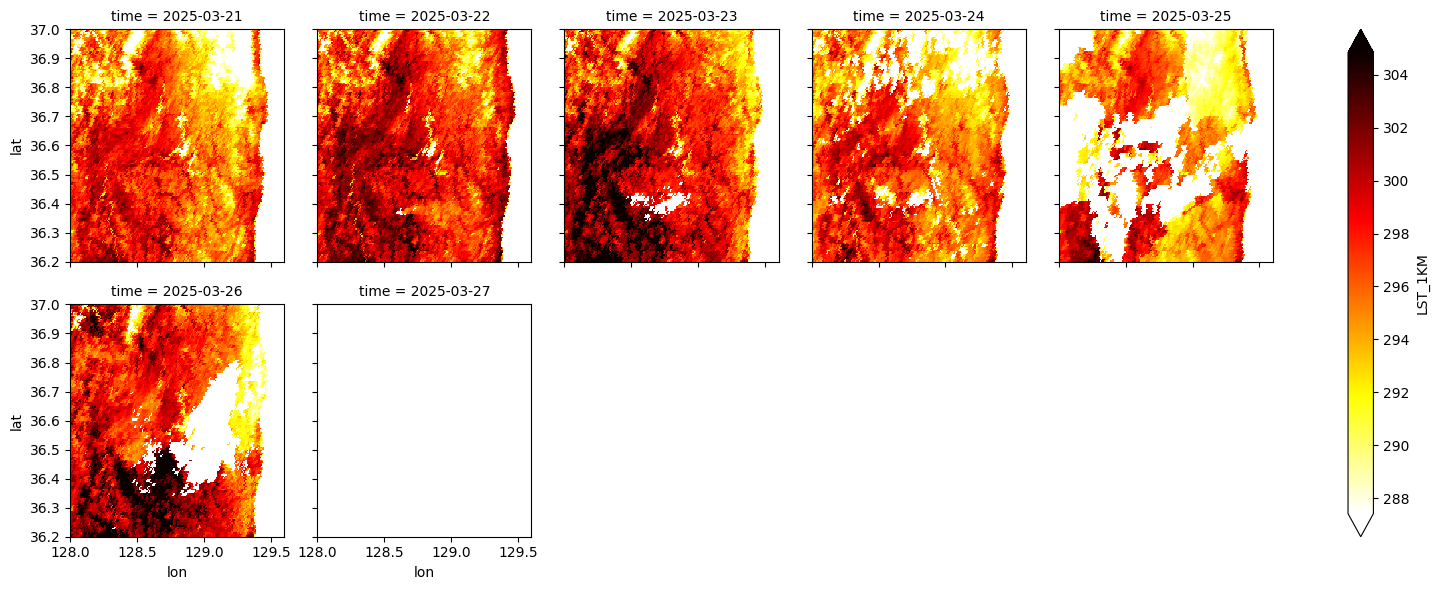

In [ ]:


ds_ndvi.ndvi.plot(x = 'lon', y ='lat', col = 'time', col_wrap = 5, robust =True, cmap = 'jet')


lst = ee.ImageCollection("NASA/VIIRS/002/VNP21A1D").select('LST_1KM').filterDate(time_start, time_end)

ds_lst = xr.open_dataset(lst, engine = 'ee', crs = 'EPSG:4326', scale = 0.005, geometry = roi)

ds_lst.LST_1KM.plot(x = 'lon', y = 'lat', cmap = 'hot_r', col = 'time', col_wrap = 5, robust = True)

To validate this, I compared NDVI anomalies to Land Surface Temperature (LST) data. Areas with sharp NDVI drops also showed elevated surface temperatures, confirming the loss of vegetative cover due to fire.


#### Limitations & Opportunities for Improvement
- On March 25, NDVI values across the region showed anomalous behavior, likely due to atmospheric interference or sensor noise.

- As of writing, data for March 27–28 is not yet available on the GEE servers, limiting full post-fire assessment. Since wildfires were officially extinguished on March 28, integrating later data could help quantify long-term environmental recovery or soil degradation.

### 2. Fire Origin Detection via VNP14A1 & MAXFRP

To identify the ignition point, I used the VNP14A1 dataset, focusing on the Maximum Fire Radiative Power (MAXFRP) over time. By mapping the temporal-spatial progression of MAXFRP on satellite basemaps, the probable origin appears near northern Gyeongsangbuk-do, consistent with local media reports.


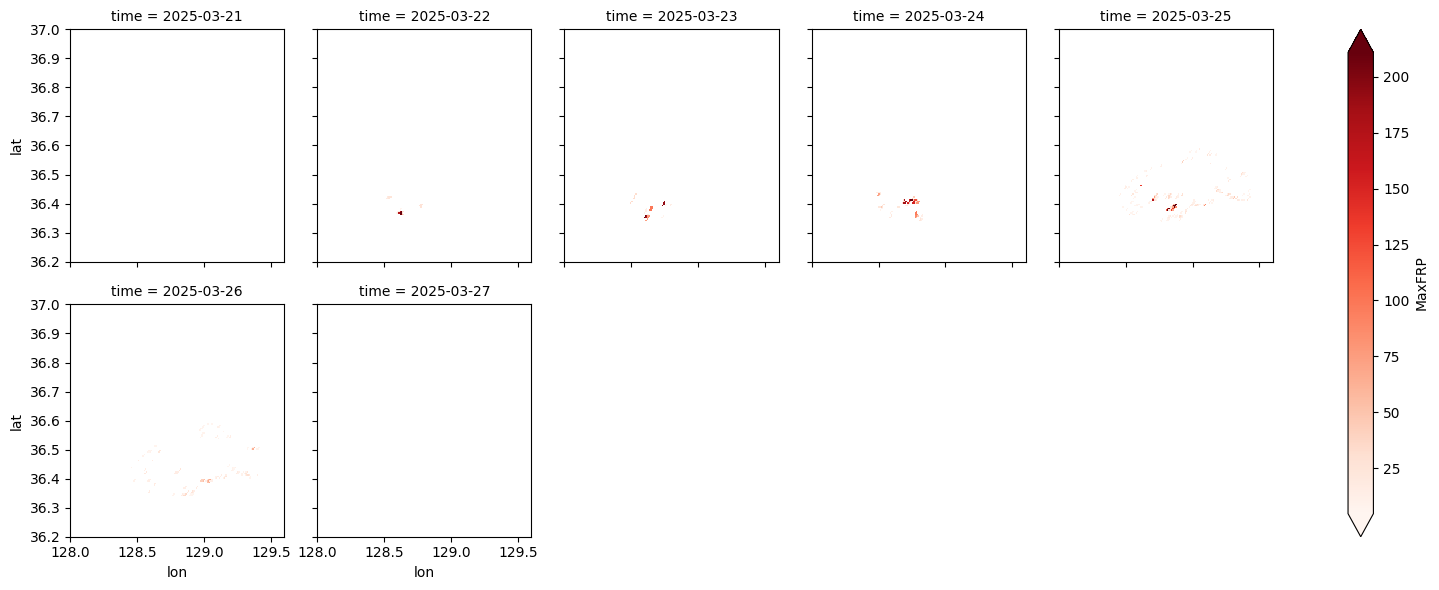

In [ ]:



temp = ee.ImageCollection("NASA/VIIRS/002/VNP14A1").select('MaxFRP').filterDate(time_start, time_end)

ds_temp = xr.open_dataset(temp, engine = 'ee', crs = 'EPSG:4326', scale = 0.005, geometry = roi)

ds_temp.MaxFRP.plot(x = 'lon', y = 'lat', cmap = 'Reds', col = 'time', col_wrap = 5, robust = True)


In [ ]:

maxfrp_img = ee.ImageCollection("NASA/VIIRS/002/VNP14A1") \
    .filterDate('2025-03-22', '2025-03-23') \
    .filterBounds(roi) \
    .select('MaxFRP') \
    .first()


Map = gee.Map(center=[36.3, 128.8], zoom=10)
Map.add_basemap('SATELLITE')
Map.addLayer(maxfrp_img, {
    'min': 10,
    'max': 300,
    'palette': ['yellow', 'orange', 'red']
}, 'Max FRP')

Map

Map(center=[36.3, 128.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

### 3. Was This Predictable? Climate Signals and Policy Inaction
Korean climatologists have warned for over a decade about increasing wildfire risk in Gyeongsang-do, driven by 30-year rising sea surface temperatures (SST). This rise promotes persistent high air pressure and seasonal air dryness — both conditions primed for large-scale wildfires.

Using NOAA SST data, I confirmed this upward trend by checking every March 22nd during 30 years, which was the particular day that wildfire ignited this year. Yet, no major regional policies were implemented to mitigate the known fire risk.




In [ ]:
#east_sea = ee.Geometry.BBox(129.3, 36.5, 131.3, 37.5)
east_sea = ee.Geometry.BBox(127.3, 34.5, 133.3, 39.5)

years = ee.List.sequence(1995, 2024)

# get the march 22nd sst data

def march_22_img(year):
    date = ee.Date.fromYMD(year, 3, 22)
    img = ee.ImageCollection("NOAA/CDR/OISST/V2_1") \
        .filterDate(date, date.advance(1, 'day')) \
        .filterBounds(east_sea) \
        .select('sst') \
        .first() \
        .set('system:time_start', date.millis()) \
        .set('year', year)
    return img

# ImageCollection
sst_march22 = ee.ImageCollection(years.map(march_22_img))


In [ ]:

ds_sst = xr.open_dataset(
    sst_march22,
    engine='ee',
    crs='EPSG:4326',
    geometry=east_sea,
    scale=0.005
)


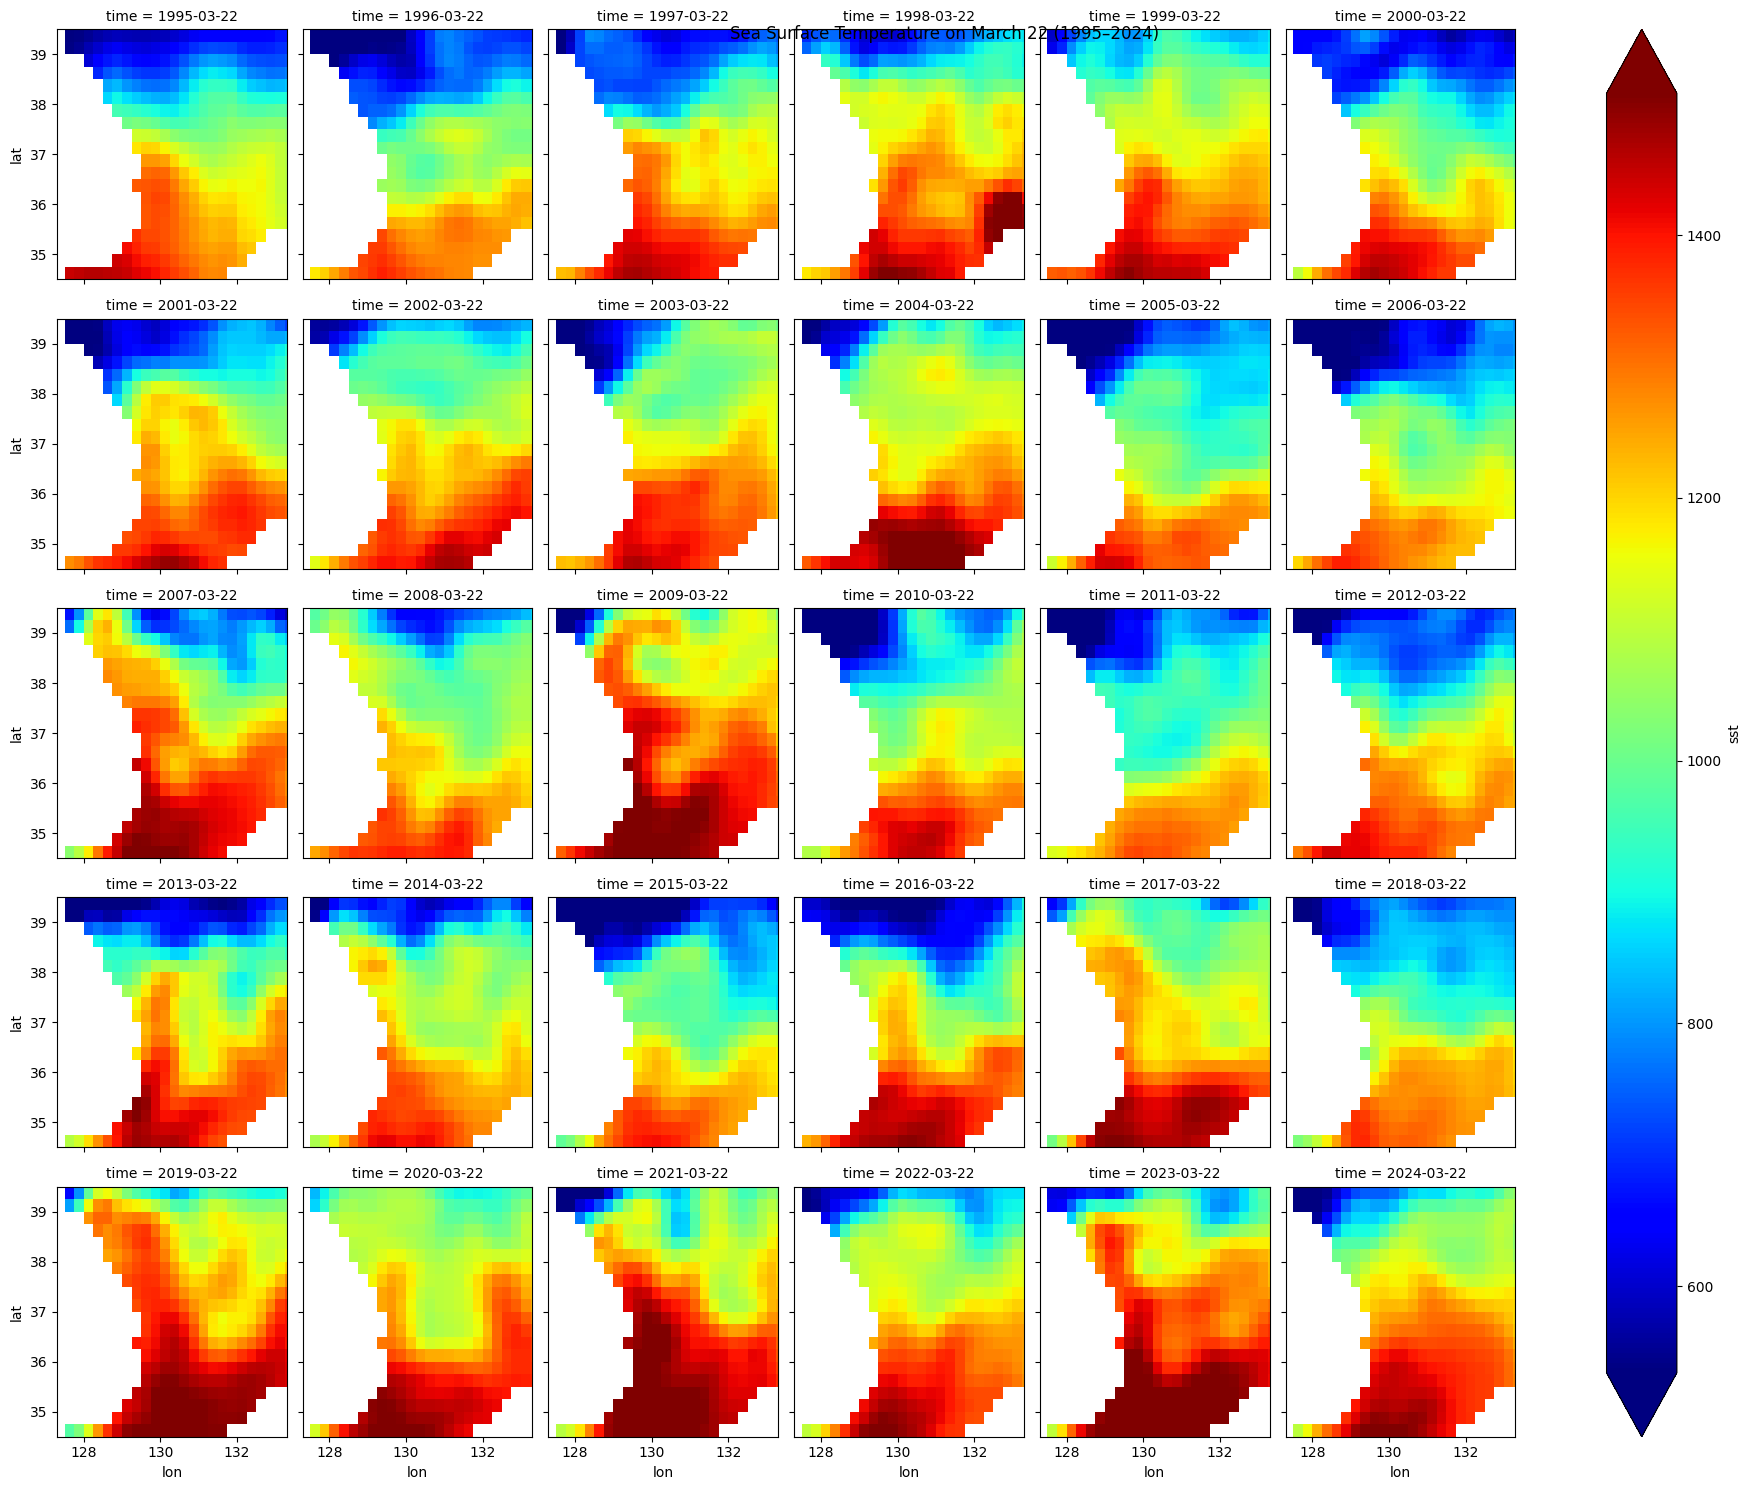

In [ ]:

ds_sst.sst.plot(
    x='lon',
    y='lat',
    col='time',
    col_wrap=6,
    cmap='jet',
    robust=True
)

plt.suptitle("Sea Surface Temperature on March 22 (1995–2024)")
plt.show()


### Reflection

This project connects my core data science skills with an urgent public policy concern, showcasing the power of spatial data in disaster response and resilience planning. I hope to apply these insights and further develop them in my studies/career.

### Tools Used
Google Earth Engine (VIIRS, VNP21A1D, VNP14A1)

Python (GEE API, matplotlib)